In [1]:
import numpy as np
import pandas as pd
from Jesse_Funcs_New.JessePlot import SpecificPlots
from Jesse_Funcs_New import blahut
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
def mean_slice(cond_slice):
    x = np.arange(len(cond_slice))
    mean_slice = np.dot(x,cond_slice)
    return mean_slice

In [3]:
def varr_slice(cond_slice):
    x = np.arange(len(cond_slice))
    mean_slice = np.dot(x,cond_slice)
    shift_x_sq = (x - mean_slice)**2
    var_slice = np.dot(shift_x_sq,cond_slice)
    return var_slice

In [4]:
def normalizer(x,new_min,new_max):
    x_max = np.amax(x)
    x_min = np.amin(x)

    return (((x-x_min)/(x_max-x_min))*(new_max-new_min)+new_min)

In [5]:
def pcm_plot(new_data, device_num, diff, color, alpha=0.5):
    device_idx = [new_data['Device'] == device_num]
    V_device = new_data['V'][device_idx[0]]
    R_device = new_data['R'][device_idx[0]]
    plt.scatter(V_device,np.log10(R_device)+diff, c=color, alpha=alpha)
    if sum(diffs == 0) == len(device_nums):
        plt.savefig('pcm_plot_unshift.png')
    else:
        plt.savefig('pcm_plot_shift.png') 

In [6]:
def get_data(data_path, plot_data = False, new_data = True, device_num=0, take_log = True):
    data = pd.read_pickle(data_path)
    
    if new_data:
        device_idx = [data['Device'] == device_num]
        V_device = np.array(data['V'][device_idx[0]])
        R_device = np.array(data['R'][device_idx[0]])
    else: 
        V_device = np.array(data['V'])
        R_device = np.array(data['R'])
    if plot_data:
        plt.figure(figsize=(20,10))
        plt.scatter(V_device,np.log10(R_device), c='green')
        
    if take_log:
        R_device = np.log10(R_device)
    
    return V_device, R_device

In [7]:
def upsample_data(V, R, to_plot_or_not_to_plot = True, resample_rate = 1000):
    
    if to_plot_or_not_to_plot:
        plt.figure(figsize=(20,10))
        plt.xlim(V[0],V[len(V)-1])
        plt.scatter(V, R, c='green')

    P_RV, V_grid, R_grid = blahut.Q(V, R, nx=resample_rate, ny=resample_rate)
    
    flipped_P_RV = np.zeros_like(P_RV)
    for i in range(len(P_RV)):
        flipped_P_RV[:,i] = np.flip(P_RV[:,i],axis=0)
        
    if to_plot_or_not_to_plot:
        plt.figure(figsize=(20,20))
        plt.imshow(flipped_P_RV, origin='lower')
    
    return flipped_P_RV, V, R

In [8]:
def varr_maker(P_RV, V, R, color = 'purple', plot_varrs = True):
    
    means = np.zeros_like(P_RV[0,:])
    for i in range(len(P_RV)):
        means[i] = mean_slice(P_RV[:,i])
        
    varr = np.zeros_like(P_RV[0,:])
    for i in range(len(P_RV)):
        varr[i] = varr_slice(P_RV[:,i])
    varr[varr < 0.0 ] = - varr[varr < 0.0 ]
    std = np.sqrt(varr)
    
    upper = means+std
    lower = means-std
    
    data_mean, data_std = blahut.moments(V, R)
    
    min_data_mean = np.amin(data_mean)
    min_data_mean_idx = np.where(data_mean == min_data_mean)
    min_data_std = data_std[min_data_mean_idx[0][0]]

    max_data_mean = np.amax(data_mean)
    max_data_mean_idx = np.where(data_mean == max_data_mean)
    max_data_std = data_std[max_data_mean_idx[0][-1]]
    
    upper_new_min = np.amin(data_mean)+min_data_std
    upper_new_max = np.amax(data_mean)+max_data_std
    lower_new_min = np.amin(data_mean)-min_data_std
    lower_new_max = np.amax(data_mean)-max_data_std
    
    upper_Rs = normalizer(upper,upper_new_min,upper_new_max)
    lower_Rs = normalizer(lower,lower_new_min,lower_new_max)
    means_Rs = normalizer(means,np.amin(data_mean),np.amax(data_mean))
    
    new_Vs = np.linspace(np.amin(V),np.amax(V), len(means_Rs))

    if plot_varrs:
        plt.figure(figsize=(20,10))

        plt.scatter(new_Vs, upper_Rs, marker='.', s=0.05, c= 'red')
        plt.scatter(np.linspace(np.amin(V),np.amax(V), len(data_mean)),data_mean+data_std, c = 'red', marker='_')

        plt.scatter(new_Vs, means_Rs, marker='.', s=0.05, c='blue')
        plt.scatter(np.linspace(np.amin(V),np.amax(V), len(data_mean)),data_mean, c = 'blue', marker='_')

        plt.scatter(new_Vs, lower_Rs, marker='.', s=0.05, c= 'red')
        plt.scatter(np.linspace(np.amin(V),np.amax(V), len(data_mean)),data_mean-data_std, c = 'red', marker='_')

        plt.figure(figsize=(20,10))
        plt.fill_between(new_Vs, lower_Rs, upper_Rs, alpha=0.5, color=color)
    
    return new_Vs, lower_Rs, upper_Rs

In [9]:
def pcm_varr_plot(data_path, device_nums, diffs, colors, alphas):
    plt.figure(figsize=(20,10))
    for i in device_nums:
        V, R = get_data(data_path, plot_data = False, new_data = True, take_log = True, device_num = device_nums[i])
        P_RV, V, R = upsample_data(V, R, to_plot_or_not_to_plot = False, resample_rate = 1000)
        new_Vs, lower_Rs, upper_Rs = varr_maker(P_RV, V, R, plot_varrs = False)
        plt.fill_between(new_Vs, lower_Rs+diffs[i], upper_Rs+diffs[i], alpha=alphas[i], color=colors[i])
    plt.xlabel(r'$V$', fontsize=18)
    plt.ylabel(r'$\log _{ 10 }{ \left( R \right)  }$ ', fontsize=18)
    if sum(diffs == 0) == len(device_nums):
        plt.savefig('pcm_varr_plot_unshift.png')
    else:
        plt.savefig('pcm_varr_plot_shift.png') 

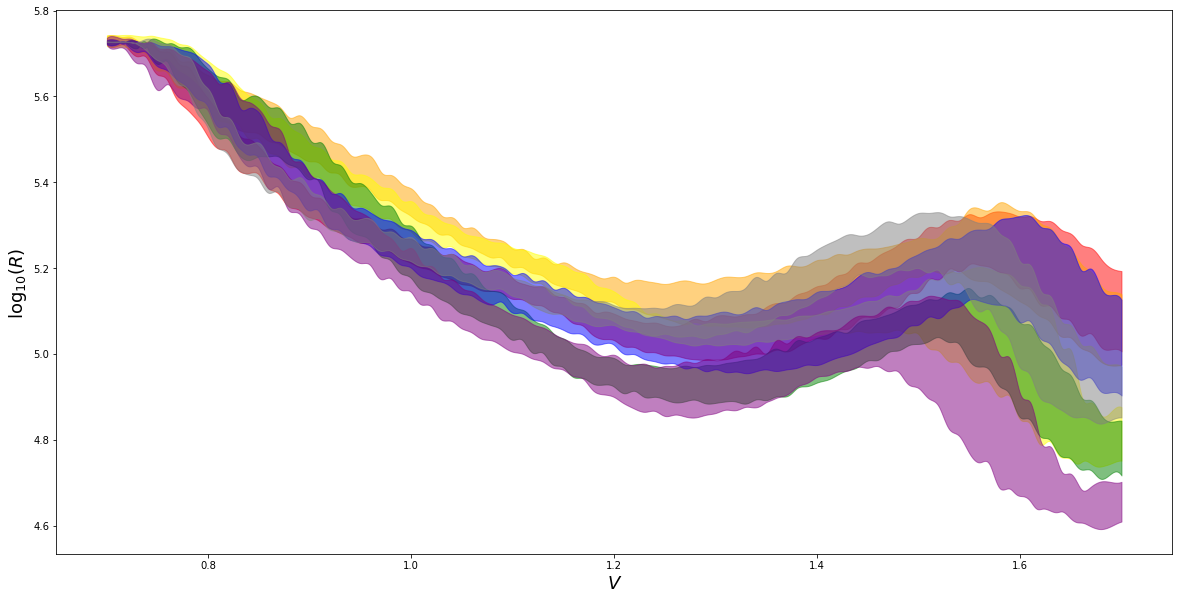

In [10]:
data_path = 'Data/PCM_20140605.pkl'
device_nums = np.arange(7)
diffs = np.array([0.32,0.4,0.12,0.115,0.235,0.0,0.26])
colors = ['red','orange','yellow','green','blue','purple','grey']
alphas = np.array([0.5]*7)


pcm_varr_plot(data_path, device_nums, diffs, colors, alphas)

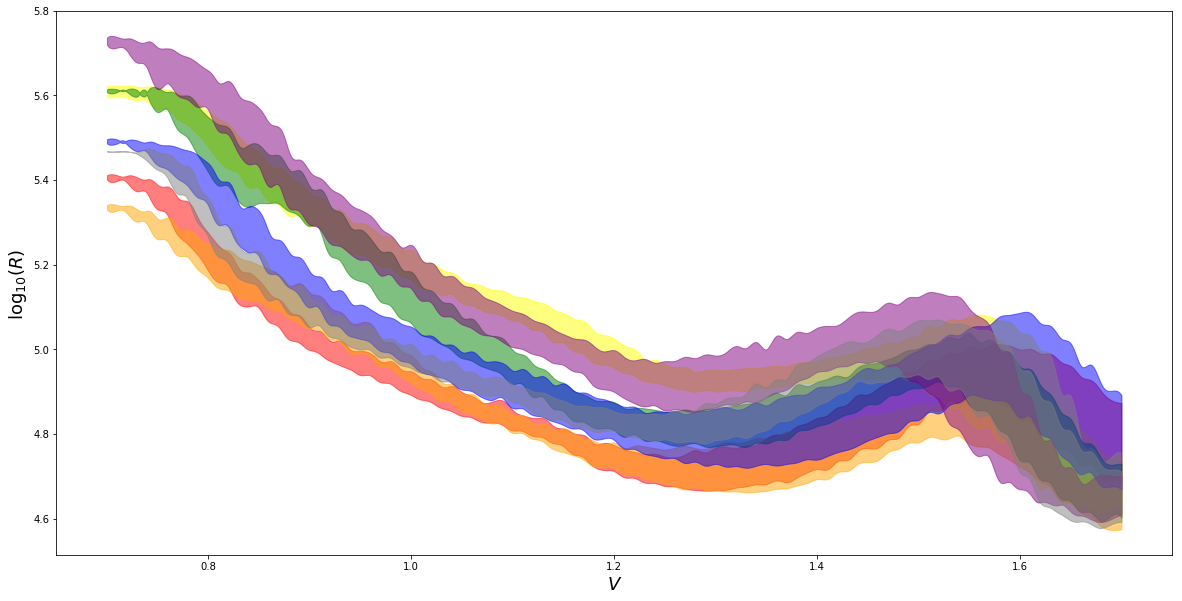

In [11]:
data_path = 'Data/PCM_20140605.pkl'
device_nums = np.arange(7)
diffs = np.zeros_like(device_nums)
colors = ['red','orange','yellow','green','blue','purple','grey']
alphas = np.array([0.5]*7)


pcm_varr_plot(data_path, device_nums, diffs, colors, alphas)

In [12]:
new_data = pd.read_pickle('Data/PCM_20140605.pkl')
diffs = np.array([0.32,0.4,0.12,0.115,0.235,0.0,0.26])
colors = ['red','orange','yellow','green','blue','purple','grey']

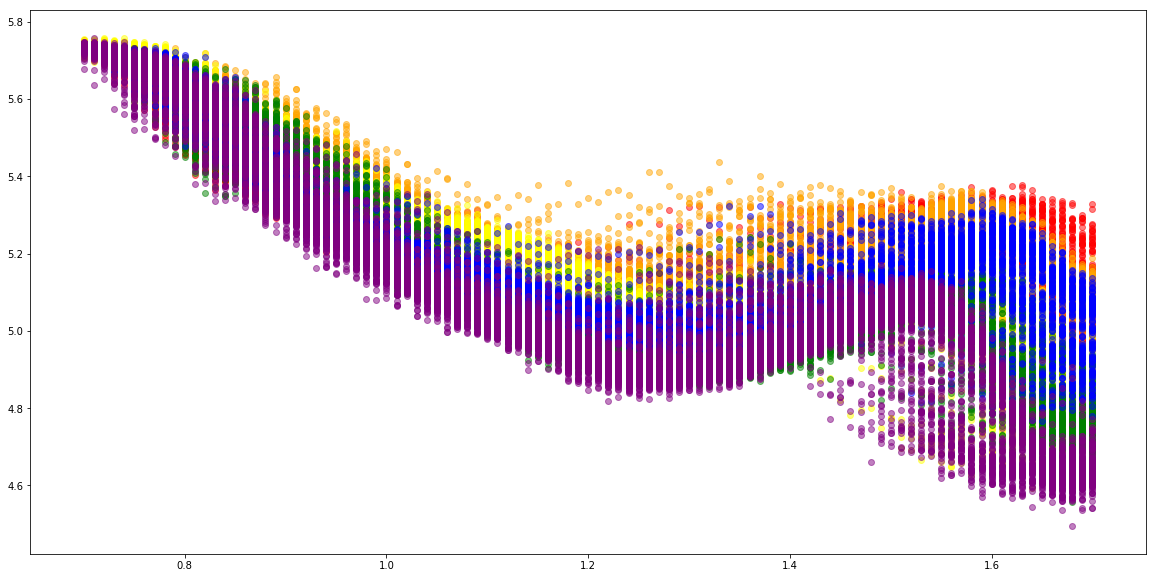

In [13]:
plt.figure(figsize=(20,10))
for i in np.arange(6):
    pcm_plot(new_data,i, diffs[i], colors[i])

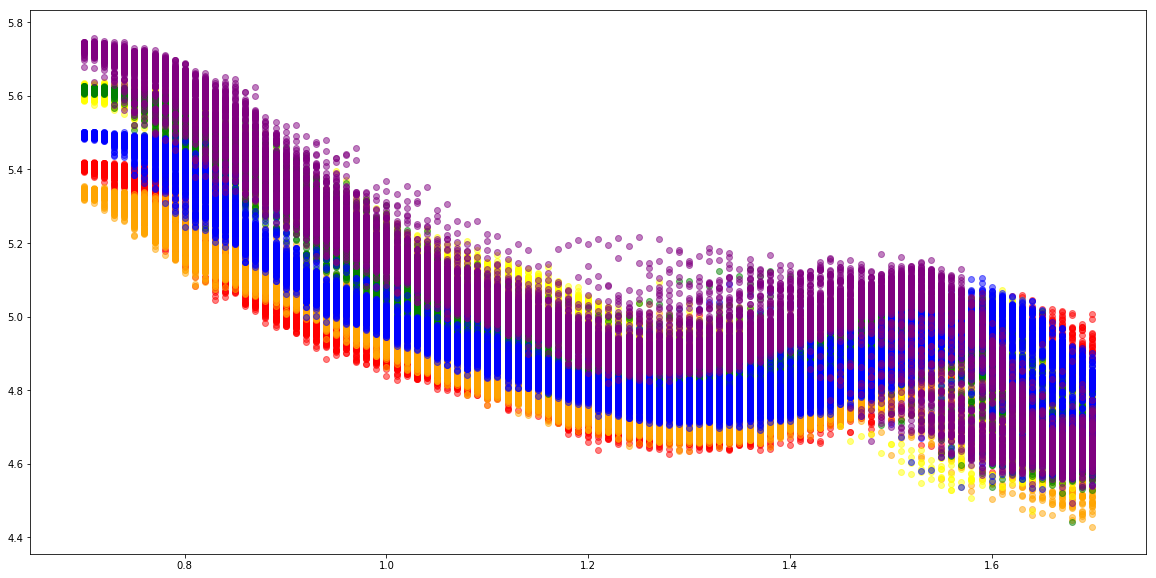

In [14]:
diffs=np.zeros(7)
plt.figure(figsize=(20,10))
for i in np.arange(6):
    pcm_plot(new_data,i, diffs[i], colors[i])

In [15]:
def pcm_varr_plot_orig(data_path, device_nums, diffs, colors, alphas):
    plt.figure(figsize=(20,10))
    for i in device_nums:
        V, R = get_data(data_path, plot_data = False, new_data = True, take_log = True, device_num = device_nums[i])
        data_mean, data_std = blahut.moments(V, R)
        new_Vs = np.linspace(np.amin(V), np.amax(V),len(data_mean))
        lower_Rs = data_mean-data_std
        upper_Rs = data_mean+data_std
        plt.fill_between(new_Vs, lower_Rs+diffs[i], upper_Rs+diffs[i], alpha=alphas[i], color=colors[i])
    plt.xlabel(r'V', fontsize=18)
    plt.ylabel(r'$\log _{ 10 }{ \left( R \right)  }$ ', fontsize=18)
    if sum(diffs == 0) == len(device_nums):
        plt.savefig('pcm_varr_plot_orig_unshift.png')
    else:
        plt.savefig('pcm_varr_plot_orig_shift.png')        

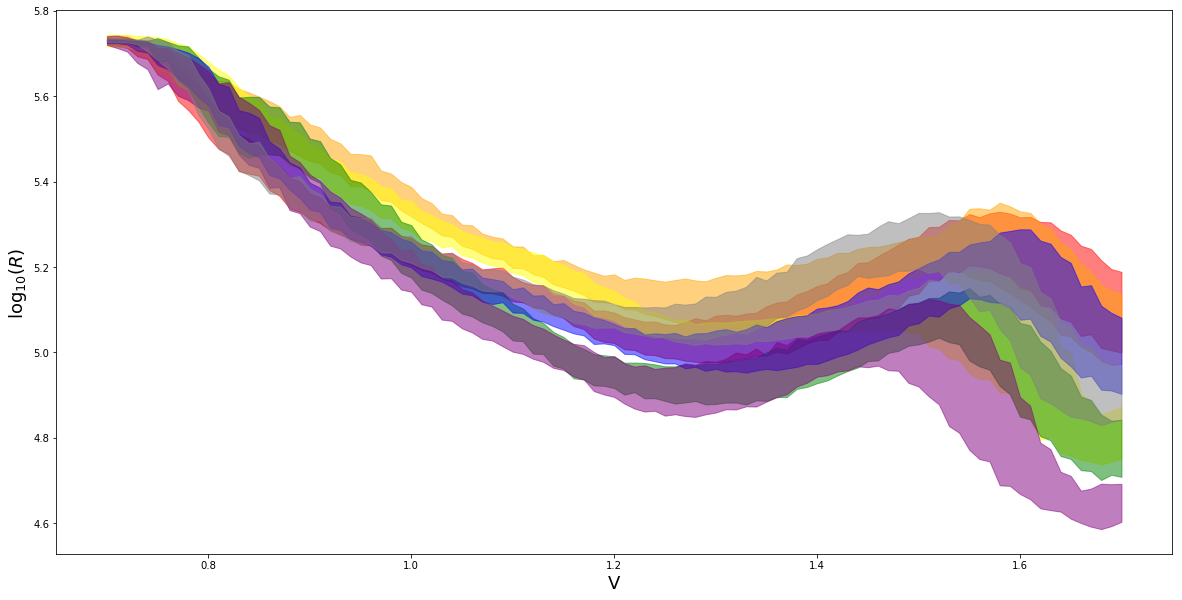

In [16]:
data_path = 'Data/PCM_20140605.pkl'
device_nums = np.arange(7)
diffs = np.array([0.32,0.4,0.12,0.115,0.235,0.0,0.26])
colors = ['red','orange','yellow','green','blue','purple','grey']
alphas = np.array([0.5]*7)


pcm_varr_plot_orig(data_path, device_nums, diffs, colors, alphas)

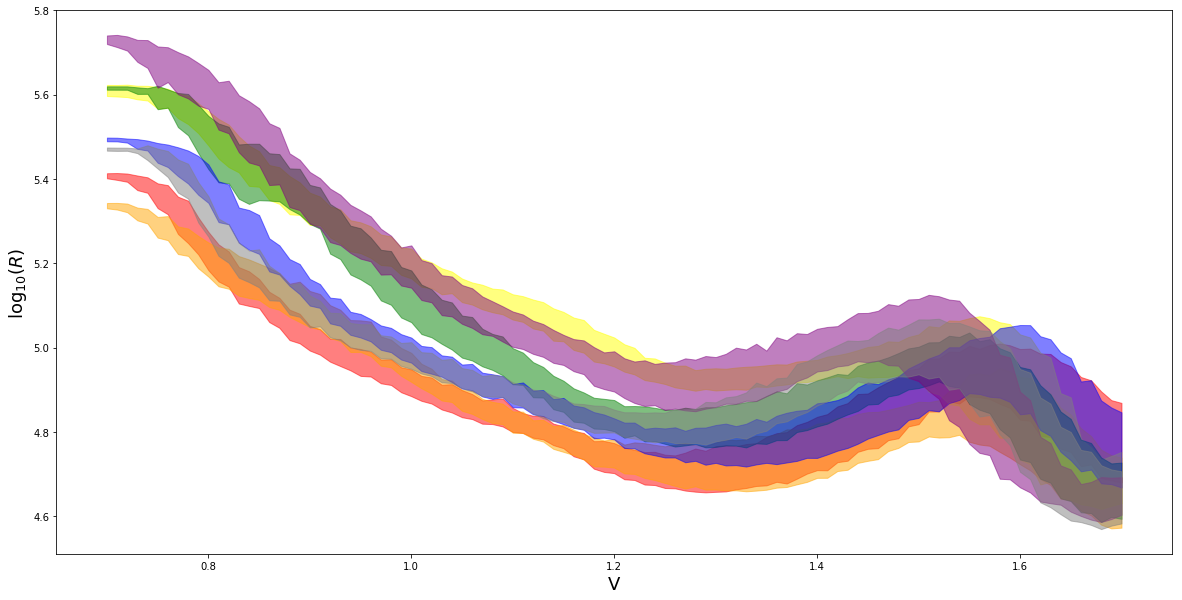

In [17]:
data_path = 'Data/PCM_20140605.pkl'
device_nums = np.arange(7)
diffs = np.zeros_like(device_nums)
colors = ['red','orange','yellow','green','blue','purple','grey']
alphas = np.array([0.5]*7)


pcm_varr_plot_orig(data_path, device_nums, diffs, colors, alphas)

In [18]:
def super_channel(data_path, device_nums, diffs, colors, alphas):
    plt.figure(figsize=(20,10))
    V, R = get_data(data_path, plot_data = False, new_data = True, take_log = True, device_num = 0)
    R = R+diffs[0]
    for i in device_nums[1:]:
        V_new, R_new = get_data(data_path, plot_data = False, new_data = True, take_log = True, device_num = device_nums[i])
        V = np.append(V,V_new)
        R = np.append(R,R_new+diffs[i])
    plt.scatter(V,R)
    plt.savefig('super_channel.png')        
    
    plt.figure(figsize=(20,10))
    data_mean, data_std = blahut.moments(V, R)    
    new_Vs = np.linspace(np.amin(V), np.amax(V),len(data_mean))
    lower_Rs = data_mean-data_std
    upper_Rs = data_mean+data_std
    plt.fill_between(new_Vs, lower_Rs, upper_Rs, alpha=alphas[i], color=colors[i])
    plt.xlabel(r'V', fontsize=18)
    plt.ylabel(r'$\log _{ 10 }{ \left( R \right)  }$ ', fontsize=18)
    plt.savefig('super_channel_varr.png')        

    return V, R 

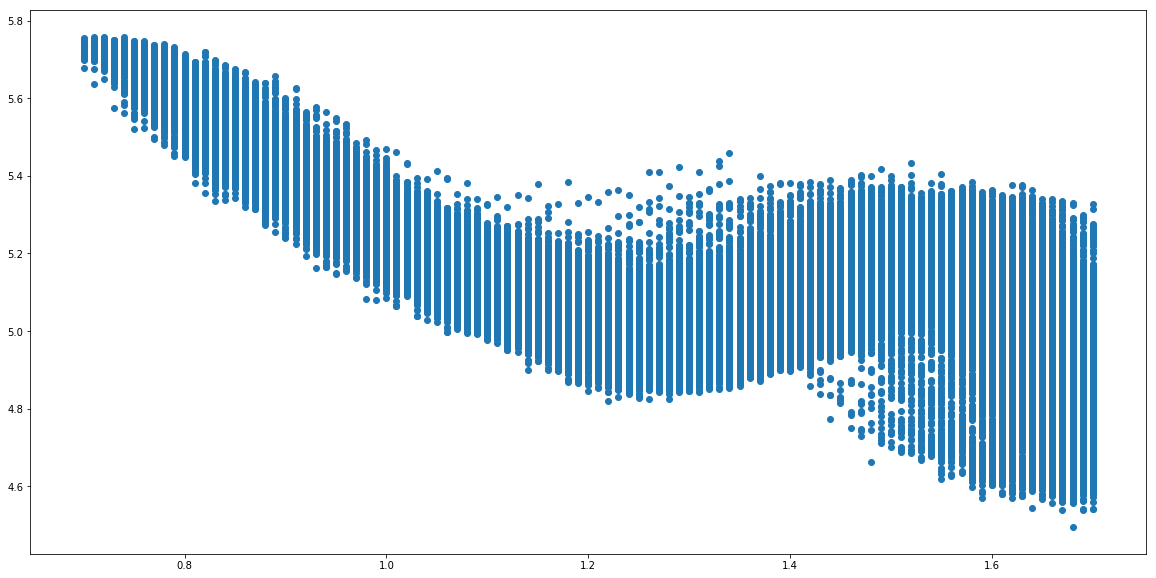

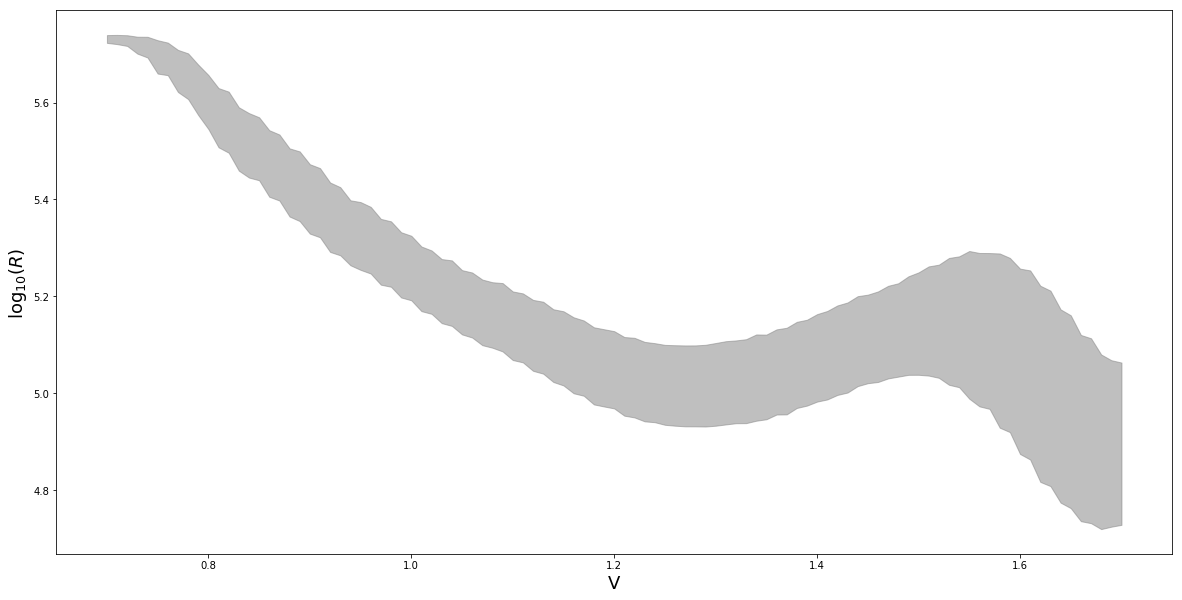

In [19]:
data_path = 'Data/PCM_20140605.pkl'
device_nums = np.arange(7)
diffs = np.array([0.32,0.4,0.12,0.115,0.235,0.0,0.26])
colors = ['red','orange','yellow','green','blue','purple','grey']
alphas = np.array([0.5]*7)


V_super, R_super = super_channel(data_path, device_nums, diffs, colors, alphas)

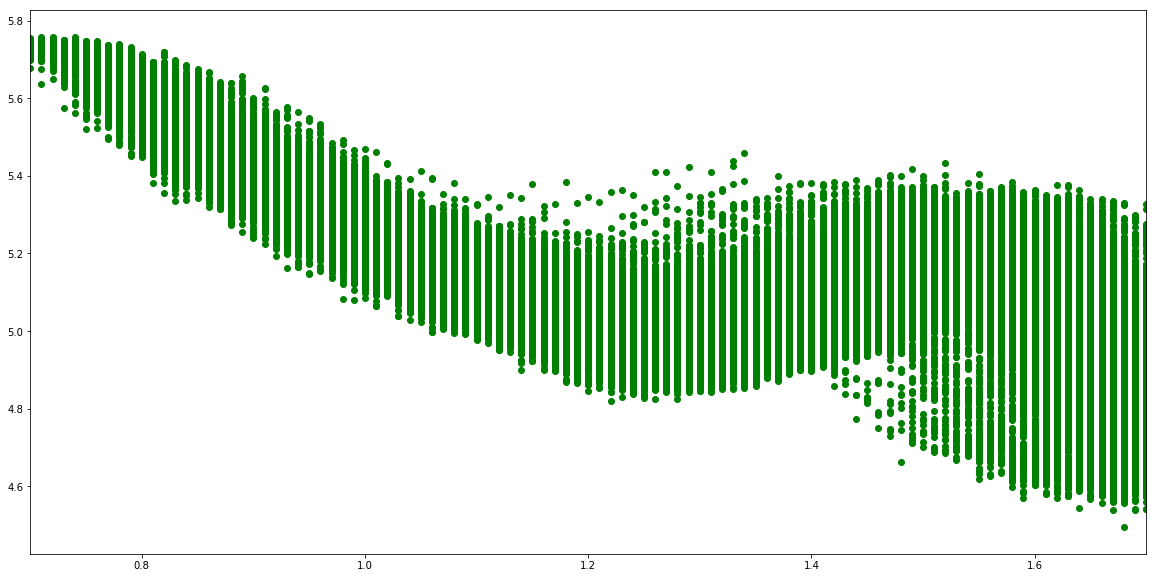

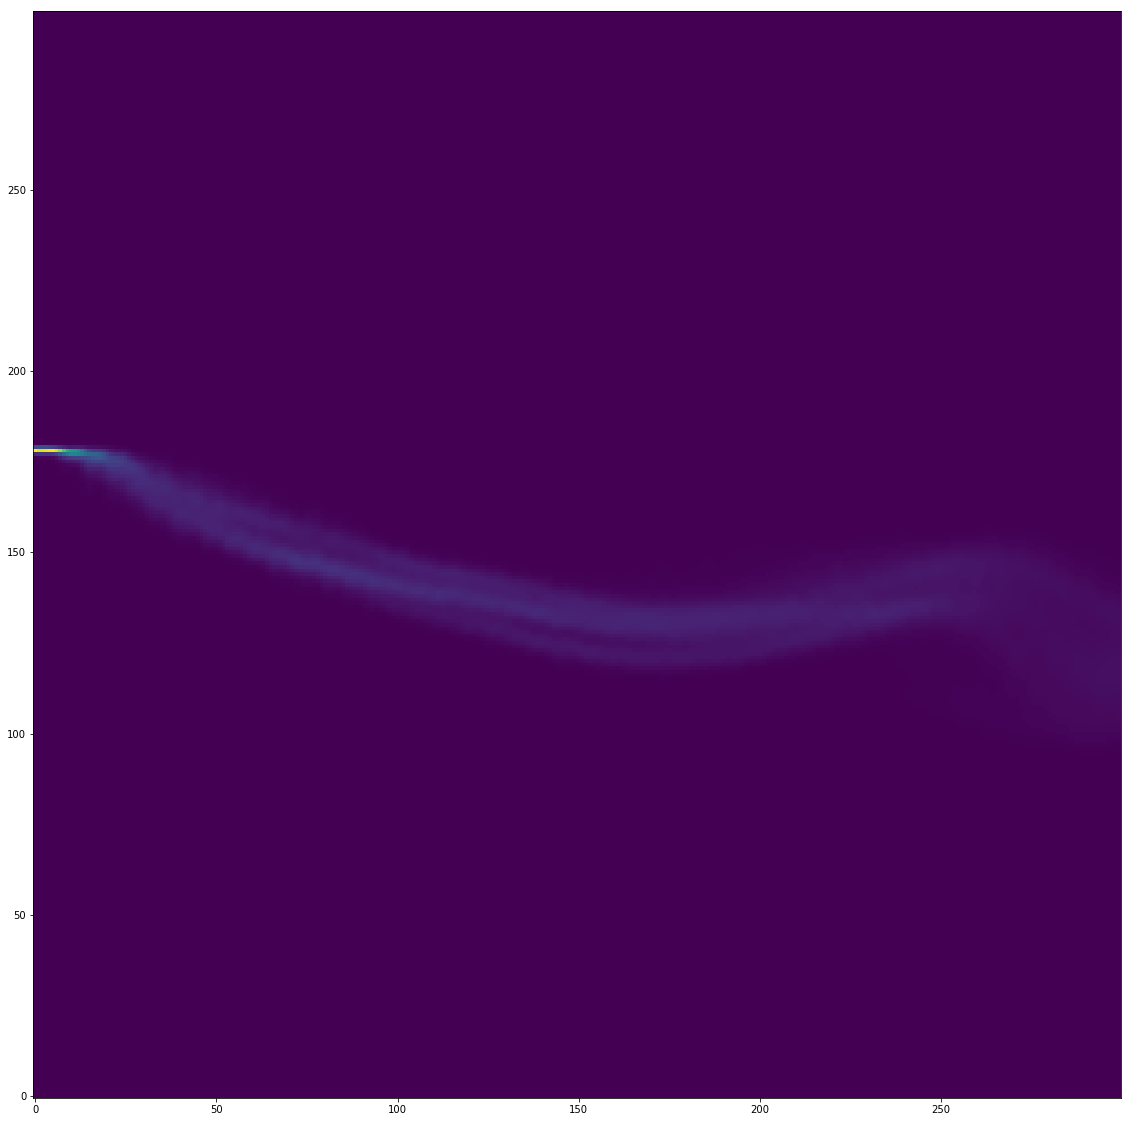

In [20]:
flipped_P_RV, V, R = upsample_data(V_super, R_super, to_plot_or_not_to_plot = True, resample_rate = 300)

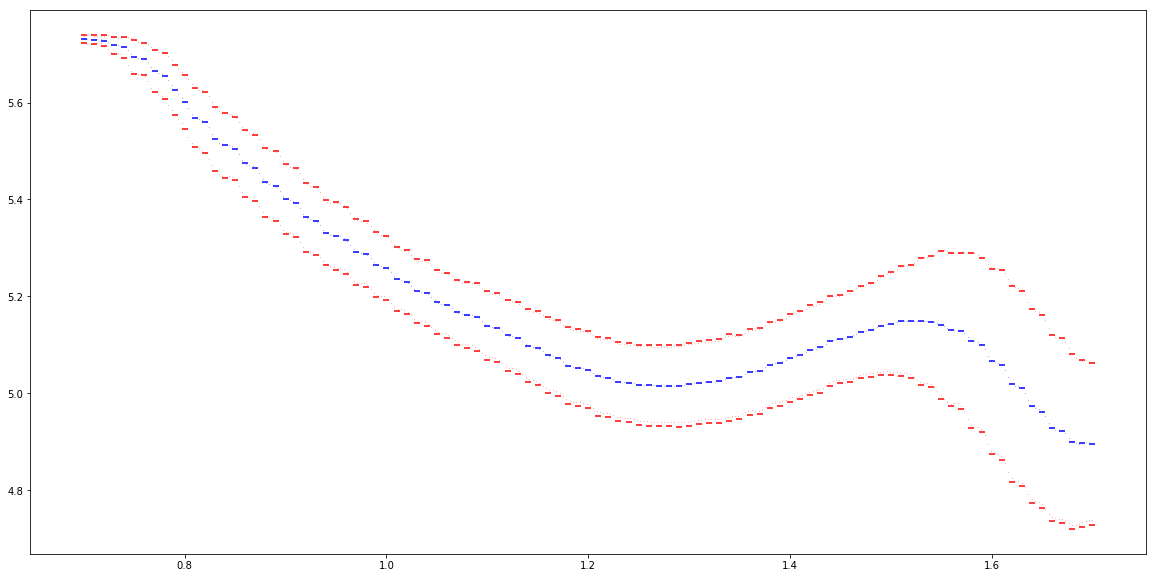

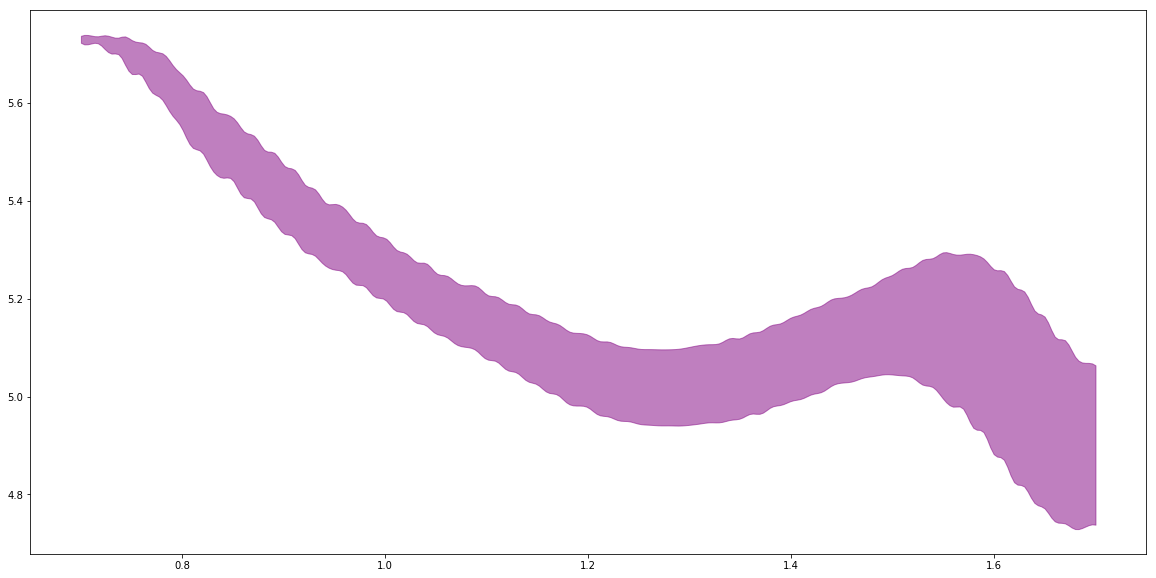

In [21]:
varr_maker(flipped_P_RV, V, R, color = 'purple', plot_varrs = True);

/Users/zarcone/Documents/Berkeley/Bruno_Lab/PCM_Paper/Jesse_Funcs_New/blahut.py:62: RuntimeWarning: divide by zero encountered in log2
  d = p * np.log2(p / np.r_[q])
/Users/zarcone/Documents/Berkeley/Bruno_Lab/PCM_Paper/Jesse_Funcs_New/blahut.py:62: RuntimeWarning: invalid value encountered in log2
  d = p * np.log2(p / np.r_[q])
/Users/zarcone/Documents/Berkeley/Bruno_Lab/PCM_Paper/Jesse_Funcs_New/blahut.py:62: RuntimeWarning: invalid value encountered in multiply
  d = p * np.log2(p / np.r_[q])
/Users/zarcone/Documents/Berkeley/Bruno_Lab/PCM_Paper/Jesse_Funcs_New/blahut.py:62: RuntimeWarning: invalid value encountered in true_divide
  d = p * np.log2(p / np.r_[q])


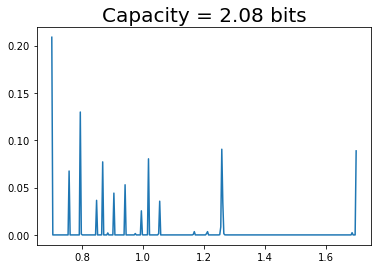

In [22]:
C,Px = blahut.blahut_arimoto(flipped_P_RV)
plt.plot(np.linspace(V[0],V[-1],len(Px)),Px)
plt.title('Capacity = '+str(round(C,2)) +' bits', fontsize=20)
plt.savefig('source_distribution.png')